In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


In [61]:
# Load the data
df = pd.read_csv('climate_visitor_snow.csv', index_col=0)
df = df.loc[:, ~df.columns.str.contains('Mt. Stirling')]

In [62]:
# Display rows with any missing values
missing_rows = df[df.isnull().any(axis=1)]
print(f"Number of rows with missing values: {len(missing_rows)}")
missing_rows


Number of rows with missing values: 439


,Year,Week,Resort,Visitors,MaxTemp,MinTemp,Rainfall,Total Snowfall,Snowfall Days,Average Base Depth,Max Base Depth,Biggest Snowfall
90,2020,1,Mt. Baw Baw,1074,5.357143,1.400000e-01,20.4,13.0,2.0,NaN,0.0,8.0
91,2020,2,Mt. Baw Baw,544,3.614286,2.142857e-01,20.2,13.0,2.0,NaN,0.0,8.0
92,2020,3,Mt. Baw Baw,603,3.271429,-1.428571e+00,55.0,13.0,2.0,NaN,0.0,8.0
93,2020,4,Mt. Baw Baw,2168,2.300000,-1.416667e+00,61.4,13.0,2.0,NaN,0.0,8.0
94,2020,5,Mt. Baw Baw,4055,3.420000,-1.850372e-17,75.8,13.0,2.0,NaN,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1480,2024,11,Charlotte Pass,2667,4.900000,-3.071429e-01,29.6,54.0,17.0,NaN,0.0,10.0
1481,2024,12,Charlotte Pass,2392,3.542857,-2.500000e-01,81.1,54.0,17.0,NaN,0.0,10.0
1482,2024,13,Charlotte Pass,1323,6.300000,-1.428571e-02,32.3,54.0,17.0,NaN,0.0,10.0
1483,2024,14,Charlotte Pass,454,7.414286,-9.857143e-01,8.4,54.0,17.0,NaN,0.0,10.0


In [63]:
df['is_covid_affected'] = df['Year'].isin([2020, 2021]).astype(int)

# Flag school holiday weeks (e.g., weeks 5 and 6)
holiday_weeks = [5, 6]
df['is_school_holiday'] = df['Week'].isin(holiday_weeks).astype(int)

In [73]:

# --- Initial Data Preparation ---
# Replace 0 with NaN for specific columns where 0 is effectively "missing"
zero_as_missing_cols = ['Total Snowfall', 'Snowfall Days', 'Average Base Depth']
df[zero_as_missing_cols] = df[zero_as_missing_cols].replace(0, np.nan)

# --- Feature Engineering (that can be done before splitting) ---
le_resort = LabelEncoder()
df['Resort_encoded'] = le_resort.fit_transform(df['Resort'])

df['TempRange'] = df['MaxTemp'] - df['MinTemp']
df['AvgTemp'] = (df['MaxTemp'] + df['MinTemp']) / 2
df['Snow'] = df['Total Snowfall'] + df['Average Base Depth'] # Will have NaNs, handled later
df['week_sin'] = np.sin(2 * np.pi * df['Week'] / 15.0)
df['week_cos'] = np.cos(2 * np.pi * df['Week'] / 15.0)

df_sorted = df.sort_values(['Resort', 'Year', 'Week']).reset_index(drop=True)

# Rolling and lag features will create NaNs for the first few entries, which is expected.
# These will also be imputed correctly after the split.
df_sorted['visitors_rolling_mean_3w'] = df_sorted.groupby('Resort')['Visitors'].transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
df_sorted['temp_rolling_mean_3w'] = df_sorted.groupby('Resort')['AvgTemp'].transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
df_sorted['Visitors_lag1_year'] = df_sorted.groupby(['Resort', 'Week'])['Visitors'].shift(1)

# Define feature columns
feature_columns = [
    'Year', 'Resort_encoded', 'MaxTemp', 'MinTemp', 'Rainfall', 'TempRange',
    'AvgTemp', 'Snow', 'week_sin', 'week_cos', 'is_covid_affected',
    'is_school_holiday', 'visitors_rolling_mean_3w', 'temp_rolling_mean_3w',
    'Visitors_lag1_year'
]

# Target variable
target_column = 'Visitors'

# --- 1. TRAIN-TEST SPLIT (Perform this BEFORE imputation) ---
train_mask = df_sorted['Year'] < 2022
X_train = df_sorted[train_mask][feature_columns]
y_train = df_sorted[train_mask][target_column]
X_test = df_sorted[~train_mask][feature_columns]
y_test = df_sorted[~train_mask][target_column]

# --- 2. LEAKAGE-FREE IMPUTATION ---
# Calculate medians ONLY from the training data
imputation_medians = X_train.median()

# Fill NaNs in both training and test sets using the training medians
X_train.fillna(imputation_medians, inplace=True)
X_test.fillna(imputation_medians, inplace=True)

# --- Model Training ---
xgb_model = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    objective='reg:squarederror'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# --- Evaluate Performance ---
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance (Leakage-Free) - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# The prediction logic for 2026 remains the same, as it's a separate step after the model is trained.
# Just ensure that any missing data created during the prediction loop is also handled,
# perhaps by using the same 'imputation_medians' from the original training set.

Model Performance (Leakage-Free) - MAE: 6084.15, RMSE: 9063.95, R²: 0.7891


Splitting data: Training on years < 2022, Testing on years >= 2022.
Model Performance (Leakage-Free) - MAE: 6084.15, RMSE: 9063.95, R²: 0.7891
Generating predictions for the test set (2022 and onwards)...


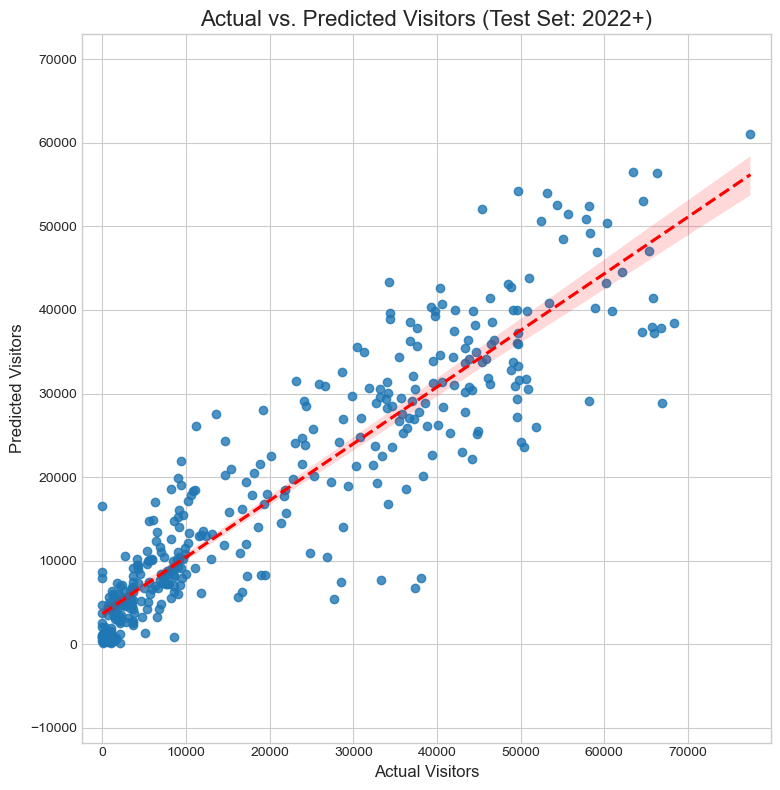

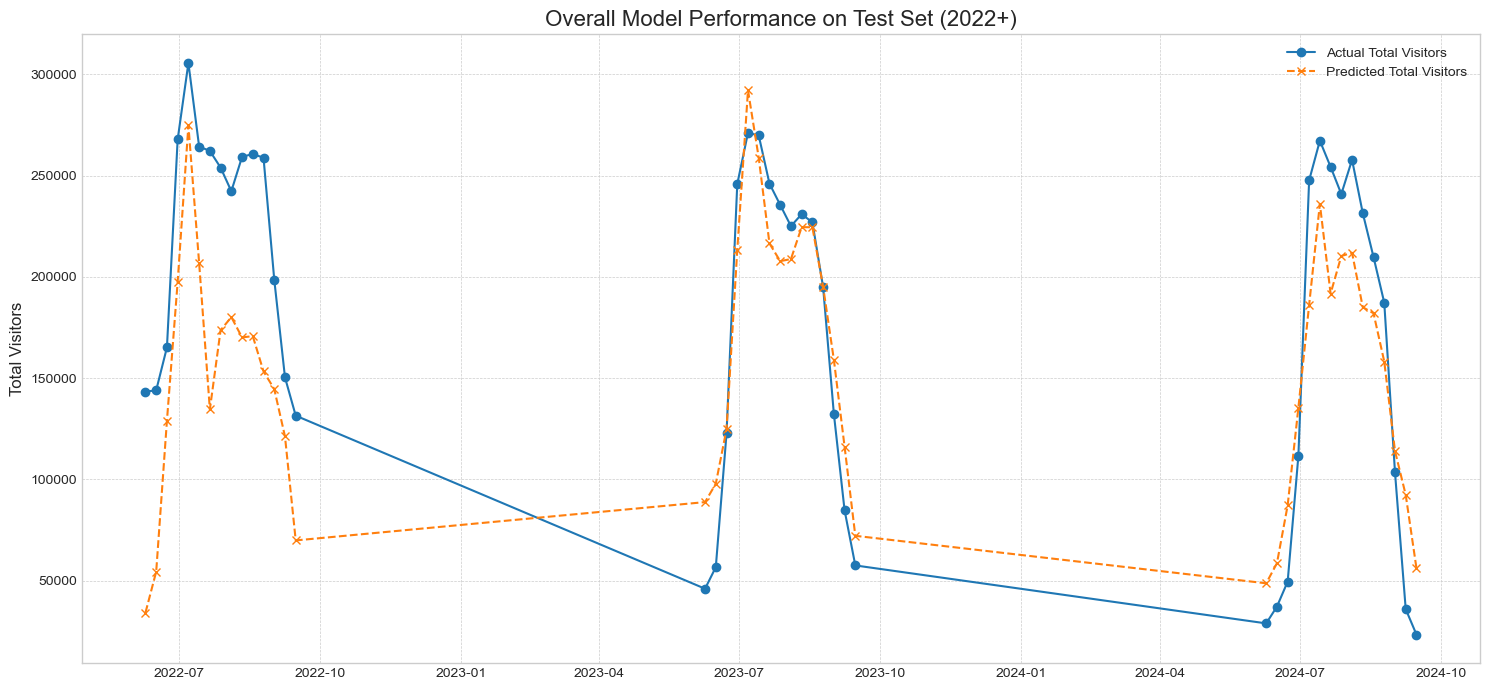


Generating individual plots for 9 resorts...


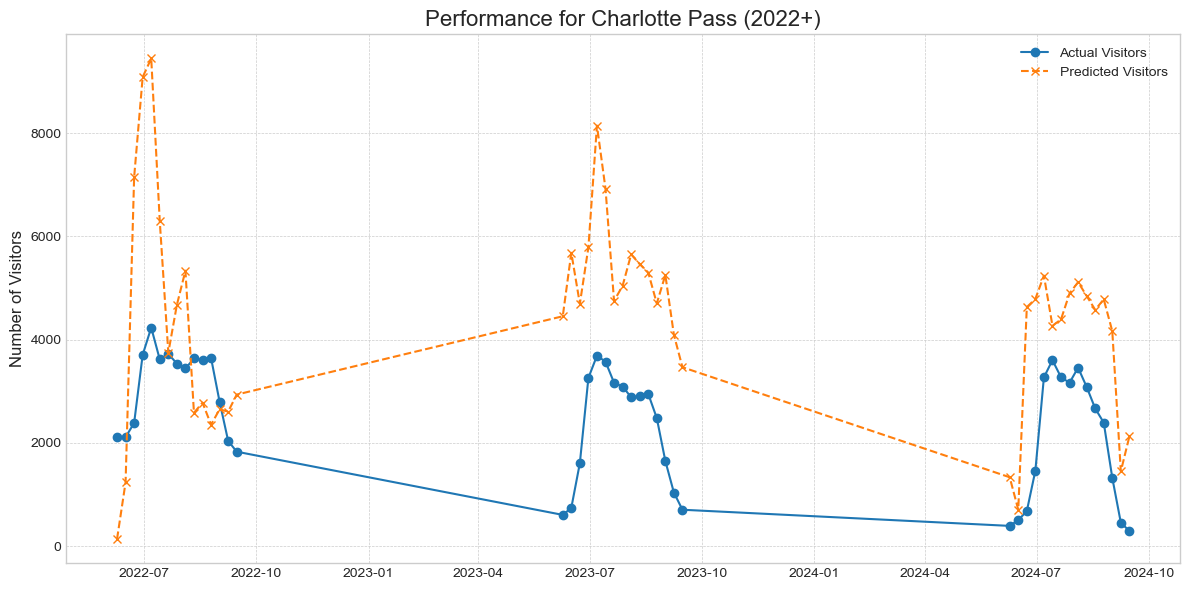

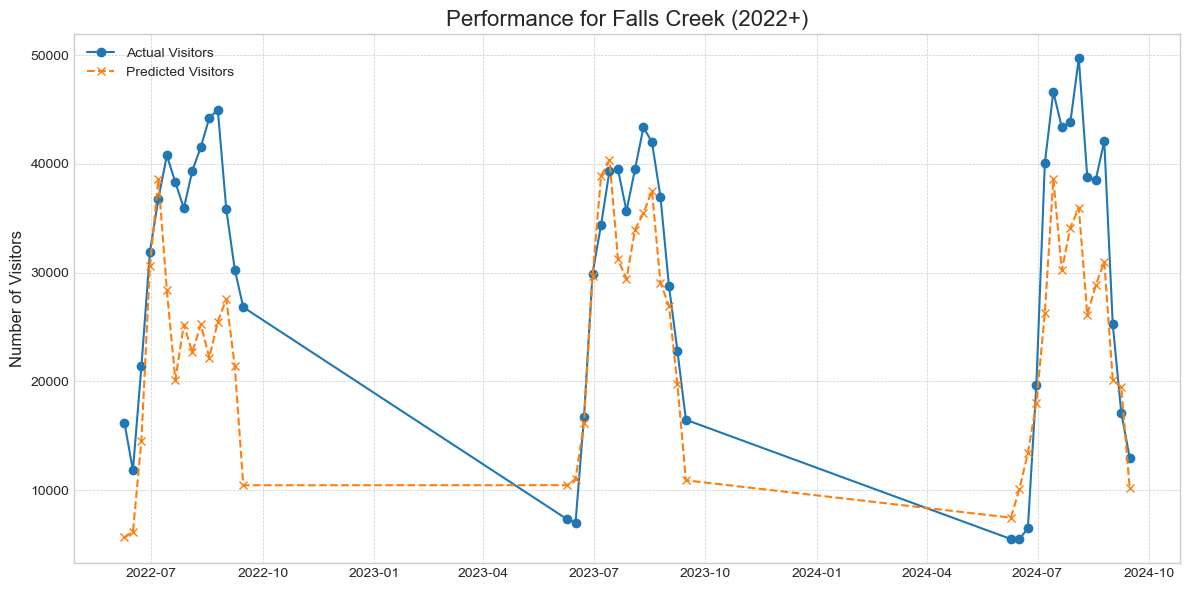

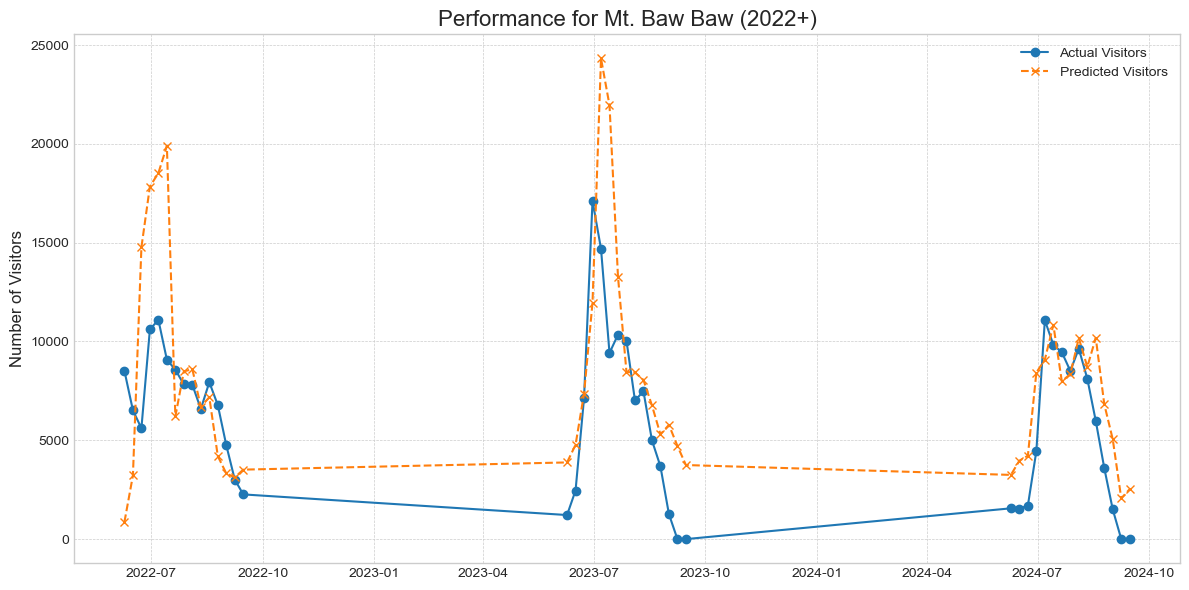

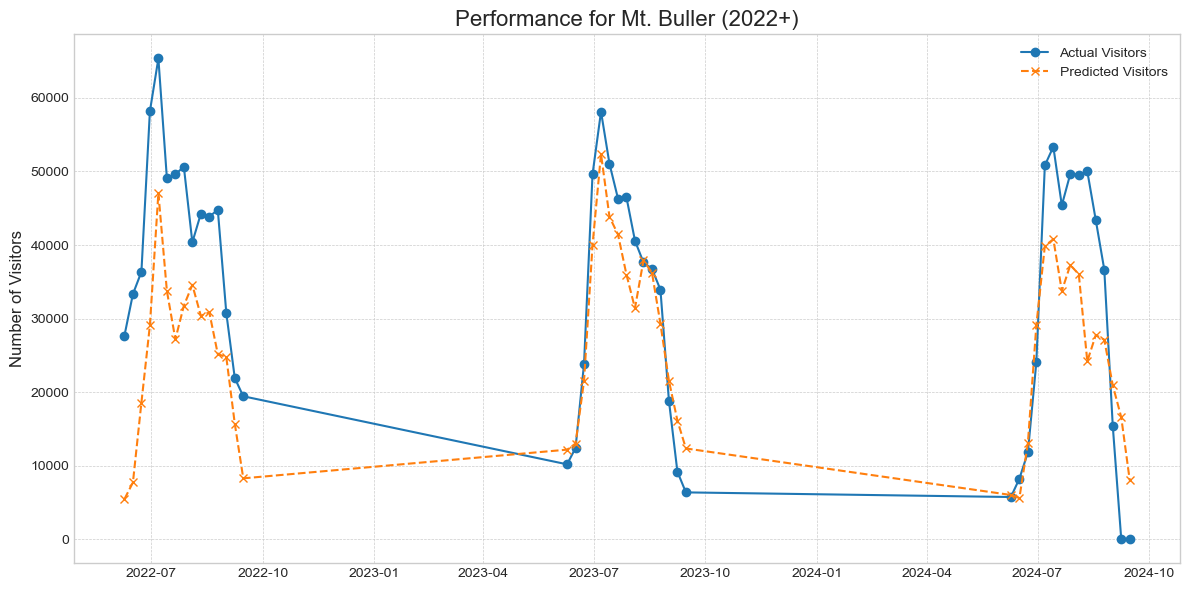

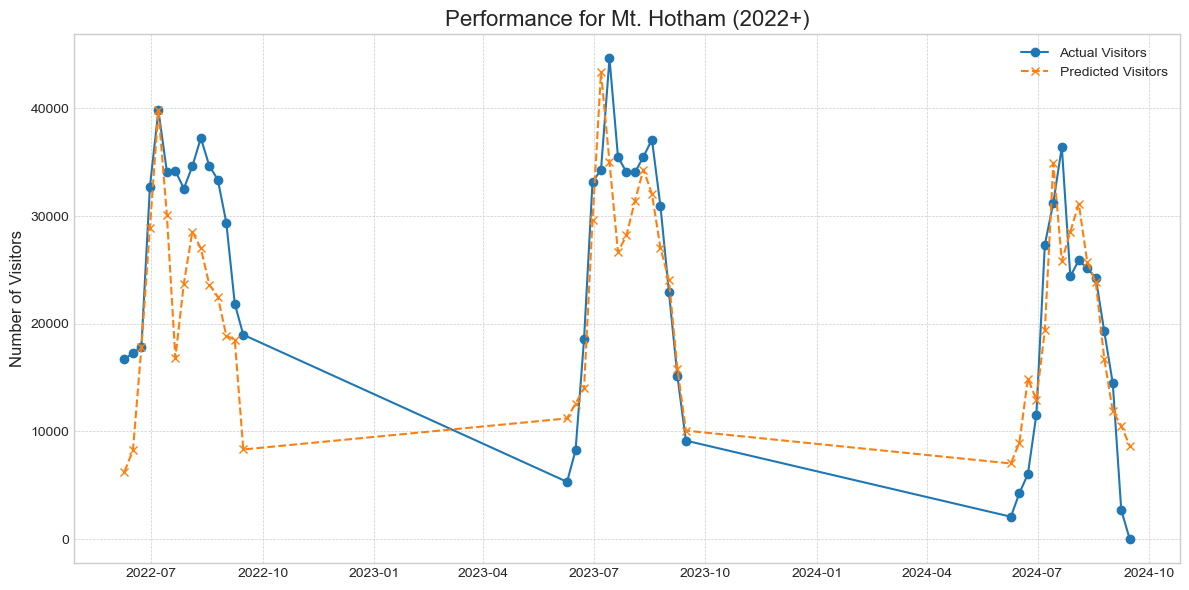

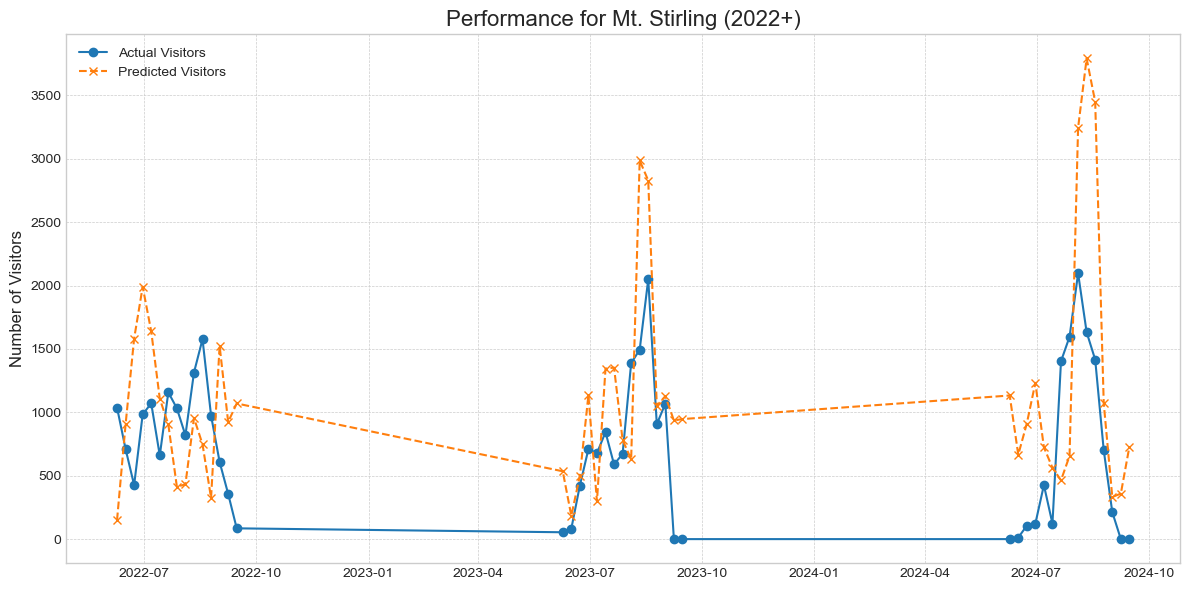

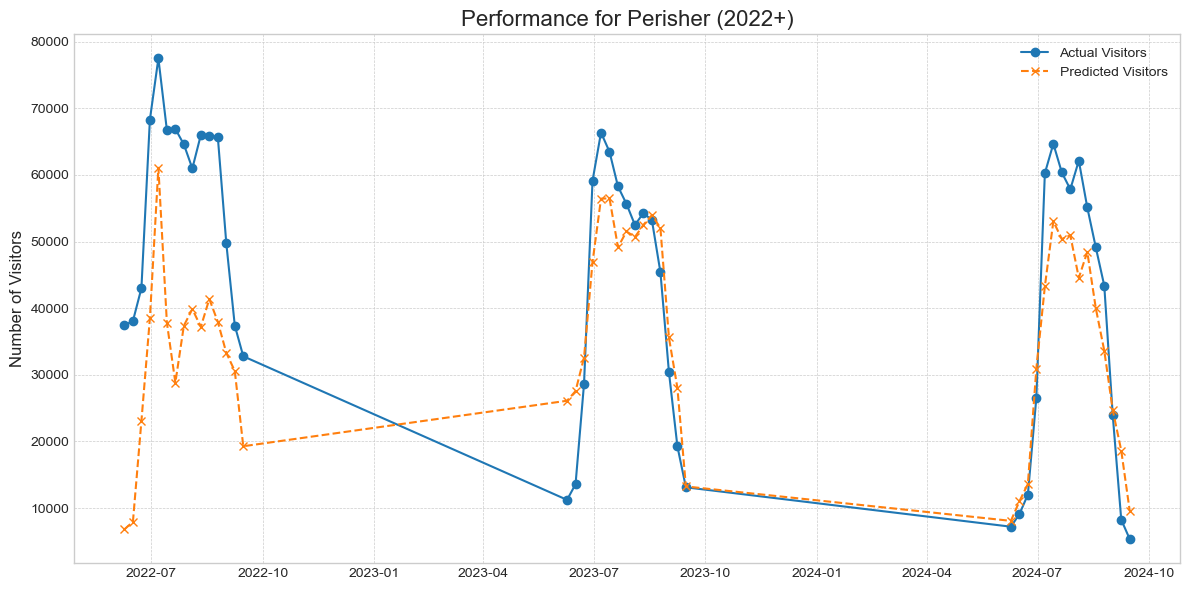

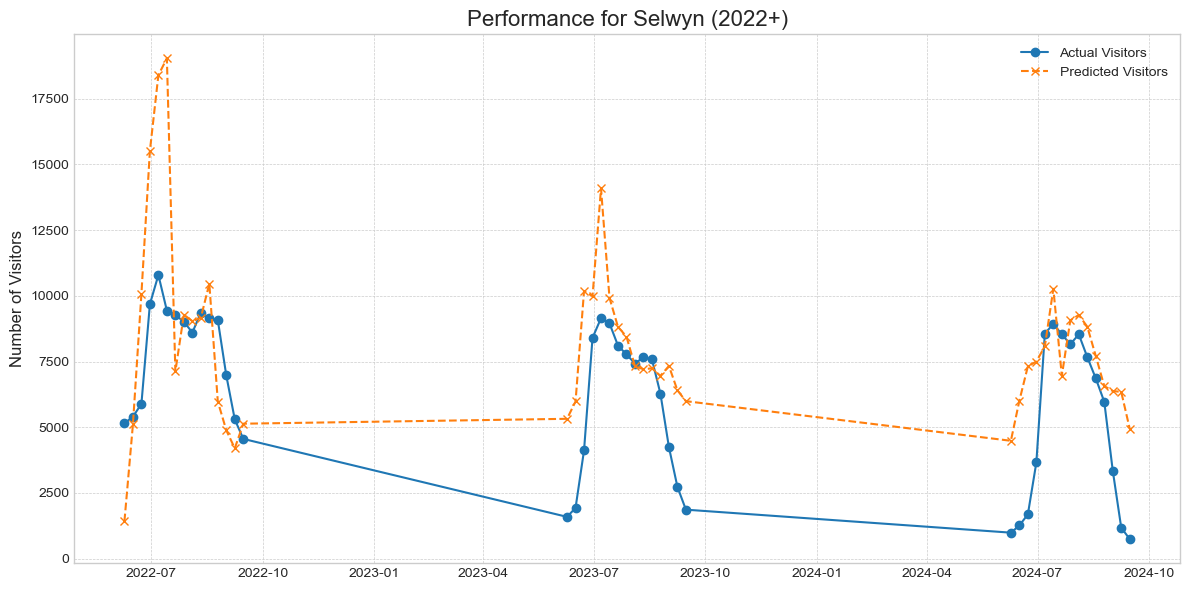

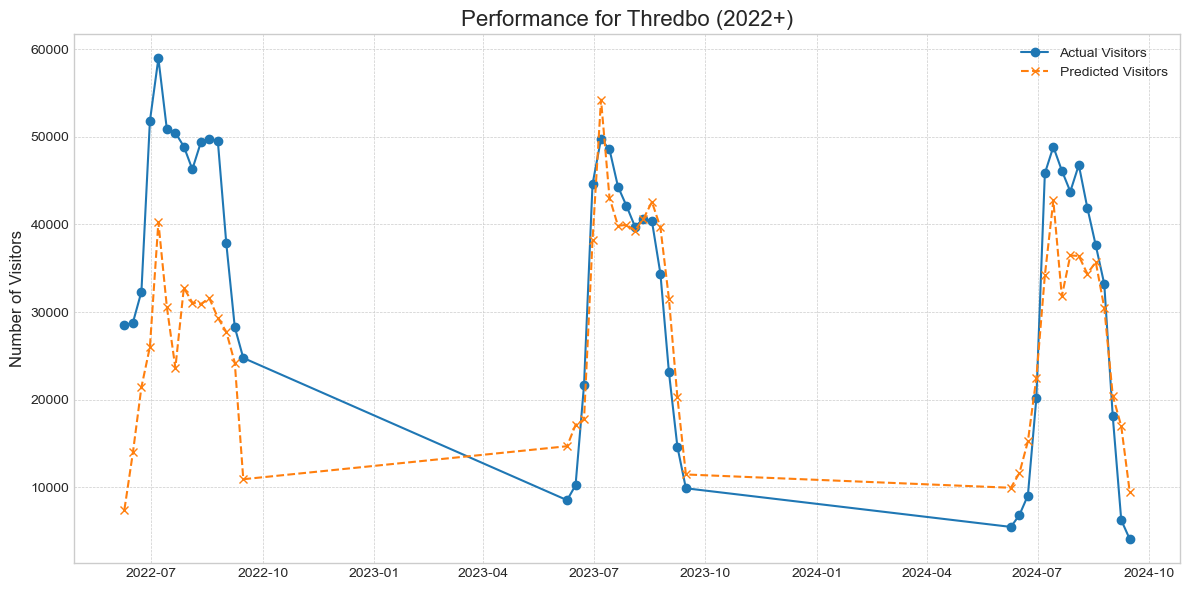

In [77]:
# --- Leakage-Free Preprocessing and Feature Engineering ---
zero_as_missing_cols = ['Total Snowfall', 'Snowfall Days', 'Average Base Depth']
df[zero_as_missing_cols] = df[zero_as_missing_cols].replace(0, np.nan)

le_resort = LabelEncoder()
df['Resort_encoded'] = le_resort.fit_transform(df['Resort'])

df['TempRange'] = df['MaxTemp'] - df['MinTemp']
df['AvgTemp'] = (df['MaxTemp'] + df['MinTemp']) / 2
df['Snow'] = df['Total Snowfall'] + df['Average Base Depth']
df['week_sin'] = np.sin(2 * np.pi * df['Week'] / 15.0)
df['week_cos'] = np.cos(2 * np.pi * df['Week'] / 15.0)

df_sorted = df.sort_values(['Resort', 'Year', 'Week']).reset_index(drop=True)

df_sorted['visitors_rolling_mean_3w'] = df_sorted.groupby('Resort')['Visitors'].transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
df_sorted['temp_rolling_mean_3w'] = df_sorted.groupby('Resort')['AvgTemp'].transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
df_sorted['Visitors_lag1_year'] = df_sorted.groupby(['Resort', 'Week'])['Visitors'].shift(1)

feature_columns = [
    'Year', 'Resort_encoded', 'MaxTemp', 'MinTemp', 'Rainfall', 'TempRange',
    'AvgTemp', 'Snow', 'week_sin', 'week_cos', 'is_covid_affected',
    'is_school_holiday', 'visitors_rolling_mean_3w', 'temp_rolling_mean_3w',
    'Visitors_lag1_year'
]
target_column = 'Visitors'

# --- 1. TRAIN-TEST SPLIT (CHANGED TO < 2022) ---
# The model now trains on data from 2021 and earlier.
# The test set contains 2022 and onwards, which have is_covid_affected=0.
print("Splitting data: Training on years < 2022, Testing on years >= 2022.")
train_mask = df_sorted['Year'] < 2022
X_train_raw = df_sorted[train_mask]
X_test_raw = df_sorted[~train_mask]

X_train = X_train_raw[feature_columns]
y_train = X_train_raw[target_column]
X_test = X_test_raw[feature_columns]
y_test = X_test_raw[target_column]

# --- 2. Leakage-Free Imputation ---
imputation_medians = X_train.median()
X_train.fillna(imputation_medians, inplace=True)
X_test.fillna(imputation_medians, inplace=True)

# --- 3. Model Training ---
xgb_model = XGBRegressor(
    n_estimators=1000, max_depth=5, learning_rate=0.05, subsample=0.8,
    colsample_bytree=0.8, random_state=42, early_stopping_rounds=50,
    objective='reg:squarederror'
)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# --- Evaluate Performance ---
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance (Leakage-Free) - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# --- Prediction and Visualization Section ---
print("Generating predictions for the test set (2022 and onwards)...")
y_pred = xgb_model.predict(X_test)

# Create a results DataFrame for easy plotting
results_df = X_test_raw.copy()
results_df['Predicted_Visitors'] = y_pred.astype(int)
results_df.rename(columns={'Visitors': 'Actual_Visitors'}, inplace=True)
results_df['Date'] = pd.to_datetime(results_df['Year'].astype(str) + '-06-09') + pd.to_timedelta((results_df['Week'] - 1) * 7, unit='d')

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Scatter Plot of Actual vs. Predicted
plt.figure(figsize=(8, 8))
sns.regplot(data=results_df, x='Actual_Visitors', y='Predicted_Visitors', line_kws={'color': 'red', 'linestyle': '--'})
plt.title('Actual vs. Predicted Visitors (Test Set: 2022+)', fontsize=16)
plt.xlabel('Actual Visitors', fontsize=12)
plt.ylabel('Predicted Visitors', fontsize=12)
plt.axis('equal')
plt.tight_layout()
plt.show()

# 2. Overall Time Series Plot
plt.figure(figsize=(15, 7))
daily_results = results_df.groupby('Date')[['Actual_Visitors', 'Predicted_Visitors']].sum()
plt.plot(daily_results.index, daily_results['Actual_Visitors'], label='Actual Total Visitors', marker='o')
plt.plot(daily_results.index, daily_results['Predicted_Visitors'], label='Predicted Total Visitors', marker='x', linestyle='--')
plt.title('Overall Model Performance on Test Set (2022+)', fontsize=16)
plt.ylabel('Total Visitors', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# 3. Per-Resort Time Series Plots
resorts = results_df['Resort'].unique()
print(f"\nGenerating individual plots for {len(resorts)} resorts...")

for resort in resorts:
    plt.figure(figsize=(12, 6))
    resort_data = results_df[results_df['Resort'] == resort].sort_values('Date')
    
    if resort_data.empty:
        print(f"Skipping plot for {resort} as it has no data in the test set.")
        continue
        
    plt.plot(resort_data['Date'], resort_data['Actual_Visitors'], label='Actual Visitors', marker='o')
    plt.plot(resort_data['Date'], resort_data['Predicted_Visitors'], label='Predicted Visitors', marker='x', linestyle='--')
    
    plt.title(f'Performance for {resort} (2022+)', fontsize=16)
    plt.ylabel('Number of Visitors', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [78]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor


print("Starting the prediction process for 2026...")

# --- 1. Preprocessing and Feature Engineering (on all data) ---
zero_as_missing_cols = ['Total Snowfall', 'Snowfall Days', 'Average Base Depth']
df[zero_as_missing_cols] = df[zero_as_missing_cols].replace(0, np.nan)

le_resort = LabelEncoder()
df['Resort_encoded'] = le_resort.fit_transform(df['Resort'])

df['TempRange'] = df['MaxTemp'] - df['MinTemp']
df['AvgTemp'] = (df['MaxTemp'] + df['MinTemp']) / 2
df['Snow'] = df['Total Snowfall'] + df['Average Base Depth']
df['week_sin'] = np.sin(2 * np.pi * df['Week'] / 15.0)
df['week_cos'] = np.cos(2 * np.pi * df['Week'] / 15.0)

df_sorted = df.sort_values(['Resort', 'Year', 'Week']).reset_index(drop=True)

df_sorted['visitors_rolling_mean_3w'] = df_sorted.groupby('Resort')['Visitors'].transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
df_sorted['temp_rolling_mean_3w'] = df_sorted.groupby('Resort')['AvgTemp'].transform(lambda x: x.rolling(window=3, min_periods=1).mean().shift(1))
df_sorted['Visitors_lag1_year'] = df_sorted.groupby(['Resort', 'Week'])['Visitors'].shift(1)

feature_columns = [
    'Year', 'Resort_encoded', 'MaxTemp', 'MinTemp', 'Rainfall', 'TempRange',
    'AvgTemp', 'Snow', 'week_sin', 'week_cos', 'is_covid_affected',
    'is_school_holiday', 'visitors_rolling_mean_3w', 'temp_rolling_mean_3w',
    'Visitors_lag1_year'
]
target_column = 'Visitors'

# Use all available data for the final training set
X_train_full = df_sorted[feature_columns]
y_train_full = df_sorted[target_column]

# Impute missing values using the median of the entire dataset
imputation_medians_full = X_train_full.median()
X_train_full.fillna(imputation_medians_full, inplace=True)

# --- 2. Train the Final Model ---
print("Training the final model on all available historical data...")
final_xgb_model = XGBRegressor(
    n_estimators=500, # Using a fixed number of estimators, no early stopping
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)
final_xgb_model.fit(X_train_full, y_train_full)
print("Model training complete.")

# --- Evaluate Performance ---
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance (Leakage-Free) - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# --- 3. Iterative Prediction for 2025 and 2026 ---
print("Generating future predictions...")
future_df = df_sorted.copy()
last_known_year = future_df['Year'].max()
years_to_predict = [last_known_year + 1, last_known_year + 2] # e.g., [2025, 2026]

for year in years_to_predict:
    print(f"  - Predicting for year {year}...")
    for resort_name in df['Resort'].unique():
        for week in range(1, 16):
            # Base the prediction on the data from the previous year (actual or predicted)
            prev_year_data = future_df[
                (future_df['Year'] == year - 1) &
                (future_df['Resort'] == resort_name) &
                (future_df['Week'] == week)
            ].tail(1)

            if prev_year_data.empty:
                continue

            # Create the feature set for the row to predict
            pred_features = prev_year_data.iloc[0:1][feature_columns].copy()
            pred_features['Year'] = year
            pred_features['is_covid_affected'] = 0 # Assume no COVID impact
            # Recalculate school holiday if necessary (logic might be more complex)
            pred_features['is_school_holiday'] = int(week in [5, 6])

            # Update lag feature with the visitor count from the previous year
            pred_features['Visitors_lag1_year'] = prev_year_data.iloc[0]['Visitors']
            
            # Use last known rolling means as a proxy
            pred_features.fillna(imputation_medians_full, inplace=True)

            # Predict
            predicted_visitors = final_xgb_model.predict(pred_features[feature_columns])[0]
            predicted_visitors = max(0, int(round(predicted_visitors)))

            # Create a full new row to append for the next iteration
            new_row_data = pred_features.iloc[0].to_dict()
            new_row_data.update({
                'Visitors': predicted_visitors,
                'Resort': resort_name,
                'Week': week,
            })
            
            future_df = pd.concat([future_df, pd.DataFrame([new_row_data])], ignore_index=True)

# --- 4. Save the Final 2026 Predictions ---
results_2026 = future_df[future_df['Year'] == years_to_predict[-1]]
results_2026 = results_2026[['Year', 'Week', 'Resort', 'Visitors']]
results_2026 = results_2026.rename(columns={'Visitors': 'Predicted_Visitors'})
results_2026 = results_2026.sort_values(['Resort', 'Week']).reset_index(drop=True)

# Save to CSV
output_filename = 'predicted_visitors_2026.csv'
results_2026.to_csv(output_filename, index=False)

print("\nPrediction complete.")
print(f"Predictions for 2026 saved to '{output_filename}'")
print("\n--- Prediction Summary ---")
print(f"Total predictions generated: {len(results_2026)} rows")
print(f"Resorts predicted: {results_2026['Resort'].nunique()}")
print(f"Weeks predicted: {results_2026['Week'].min()}-{results_2026['Week'].max()}")
print("\n--- Sample of Predictions ---")
print(results_2026.head())

Starting the prediction process for 2026...
Training the final model on all available historical data...
Model training complete.
Model Performance (Leakage-Free) - MAE: 6084.15, RMSE: 9063.95, R²: 0.7891
Generating future predictions...
  - Predicting for year 2025...
  - Predicting for year 2026...

Prediction complete.
Predictions for 2026 saved to 'predicted_visitors_2026.csv'

--- Prediction Summary ---
Total predictions generated: 135 rows
Resorts predicted: 9
Weeks predicted: 1-15

--- Sample of Predictions ---
     Year  Week          Resort  Predicted_Visitors
0  2026.0     1  Charlotte Pass                 358
1  2026.0     2  Charlotte Pass                 477
2  2026.0     3  Charlotte Pass                 182
3  2026.0     4  Charlotte Pass                1342
4  2026.0     5  Charlotte Pass                2264
